In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName('PortfolioOptimization').getOrCreate()

In [3]:
# Define the stock tickers and the period for historical data
#Microsoft, Google, Amazon, Nvidia, Visa, Coca-Cola, Goldman Sachs
tickers = ['MSFT', 'GOOG', 'AMZN','NVDA', 'V', 'KO', 'GS']
start_date = '2020-01-01'
end_date = '2023-01-01'

# Fetch stock data
def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

# Get the stock returns data
returns = fetch_stock_data(tickers, start_date, end_date)


[*********************100%%**********************]  7 of 7 completed


In [4]:
returns.shape

(755, 7)

In [6]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [7]:
mean_returns

Ticker
AMZN    0.000141
GOOG    0.000580
GS      0.000875
KO      0.000438
MSFT    0.000808
NVDA    0.001806
V       0.000358
dtype: float64

In [8]:
cov_matrix

Ticker,AMZN,GOOG,GS,KO,MSFT,NVDA,V
Ticker,,,,,,,
AMZN,0.000606,0.000364,0.000223,0.000109,0.000378,0.000576,0.000232
GOOG,0.000364,0.000469,0.000281,0.000160,0.000391,0.000540,0.000291
GS,0.000223,0.000281,0.000561,0.000209,0.000284,0.000402,0.000323
KO,0.000109,0.000160,0.000209,0.000241,0.000175,0.000185,0.000203
MSFT,0.000378,0.000391,0.000284,0.000175,0.000479,0.000591,0.000311
NVDA,0.000576,0.000540,0.000402,0.000185,0.000591,0.001243,0.000426
V,0.000232,0.000291,0.000323,0.000203,0.000311,0.000426,0.000444


In [9]:
#let's calc one covariance manually.  should be able to use np.dot.  formula from my man rivtikmath: https://www.youtube.com/watch?v=152tSYtiQbw

def cov_calc(a,b):
    a_mean, b_mean = a.mean(), b.mean()
    return (np.dot(a,b) / len(a)) - (a_mean*b_mean)


In [11]:
cov_calc(returns['KO'],returns['AMZN'])

0.00010850055643436201

In [12]:
# Convert data to Spark DataFrames
returns_df = spark.createDataFrame(returns.reset_index())
mean_returns_df = spark.createDataFrame(mean_returns.reset_index())
cov_matrix_df = spark.createDataFrame(cov_matrix.reset_index())

In [17]:
returns_df.show(5)

+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Date|                AMZN|                GOOG|                  GS|                  KO|                MSFT|                NVDA|                   V|
+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|2020-01-03 00:00:00|-0.01213903465592...|-0.00490726744803105|-0.01169346475124...|-0.00545561913041...|-0.01245157038262...|-0.01600591972214982|-0.00795314553109494|
|2020-01-06 00:00:00| 0.01488557393050649| 0.02465722511910462| 0.01023403013361901|-3.65601388996217...|0.002584854390410...|0.004193687419886...|-0.00216255630099893|
|2020-01-07 00:00:00|0.002091620415639...|-6.23992722897148...|0.006582576505598681|-0.00768260553734...|-0.00911785303986401|0.012106671125905244|-0.00264

In [22]:
#let's look at the portfolio simulation logic manually before weaponizing it...
test_result = np.zeros((6, 1))

In [23]:
test_result.shape

(6, 1)

In [24]:
#get one set of random weights to try for port balance
test_weights = np.random.random(7)

In [25]:
test_weights

array([0.24620049, 0.36356235, 0.11209105, 0.6737543 , 0.88949675,
       0.20056441, 0.84056005])

In [26]:
#reset weights as % of total, so like normalizing.  /= divides by whatever and reassigns the new value to weights.  like +=.
test_weights /= np.sum(test_weights)

In [27]:
test_weights

array([0.07401789, 0.10930165, 0.03369913, 0.20255798, 0.26741894,
       0.06029783, 0.25270658])

In [28]:
mean_returns

Ticker
AMZN    0.000141
GOOG    0.000580
GS      0.000875
KO      0.000438
MSFT    0.000808
NVDA    0.001806
V       0.000358
dtype: float64

In [29]:
#sure, just our average returns * our weights, summed
test_portfolio_return = np.dot(test_weights, mean_returns)

In [30]:
test_portfolio_return

0.0006075826099618109

In [32]:
cov_matrix.shape

(7, 7)

In [33]:
test_weights.shape

(7,)

In [34]:
cov_matrix

Ticker,AMZN,GOOG,GS,KO,MSFT,NVDA,V
Ticker,,,,,,,
AMZN,0.000606,0.000364,0.000223,0.000109,0.000378,0.000576,0.000232
GOOG,0.000364,0.000469,0.000281,0.000160,0.000391,0.000540,0.000291
GS,0.000223,0.000281,0.000561,0.000209,0.000284,0.000402,0.000323
KO,0.000109,0.000160,0.000209,0.000241,0.000175,0.000185,0.000203
MSFT,0.000378,0.000391,0.000284,0.000175,0.000479,0.000591,0.000311
NVDA,0.000576,0.000540,0.000402,0.000185,0.000591,0.001243,0.000426
V,0.000232,0.000291,0.000323,0.000203,0.000311,0.000426,0.000444


In [35]:
test_weights

array([0.07401789, 0.10930165, 0.03369913, 0.20255798, 0.26741894,
       0.06029783, 0.25270658])

In [36]:
np.dot(cov_matrix, test_weights)

array([0.00030864, 0.00033067, 0.00029031, 0.0001905 , 0.00035821,
       0.00049337, 0.00032227])

In [37]:
test_portfolio_stddev = np.sqrt(np.dot(test_weights, np.dot(cov_matrix, test_weights)))

In [38]:
test_portfolio_stddev

0.017729640469261187

Recall that port variance is sum of weighted variances of each stock, plus the covariance of each stock pair. covar can be negative (stocks move in opposite directions, which would decrease vol), or positive (move in the same direction, adding to risk).

![Covariance](covariance_formula.png)

In [39]:
# Define number of portfolios to simulate
num_portfolios = 10000

In [81]:
def simulate_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        results[2,i] = results[0,i] / results[1,i]  # Sharpe Ratio
    return results

In [82]:
results = simulate_portfolios(num_portfolios, mean_returns.values, cov_matrix.values)

In [95]:
results[:,0]

array([0.00067075, 0.02047352, 0.03276176])

In [84]:
# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_stddev = results[1, max_sharpe_idx]

print("Maximum Sharpe Ratio Portfolio Return:", max_sharpe_return)
print("Maximum Sharpe Ratio Portfolio Risk:", max_sharpe_stddev)

Maximum Sharpe Ratio Portfolio Return: 0.0009722728031226328
Maximum Sharpe Ratio Portfolio Risk: 0.0223000940724628


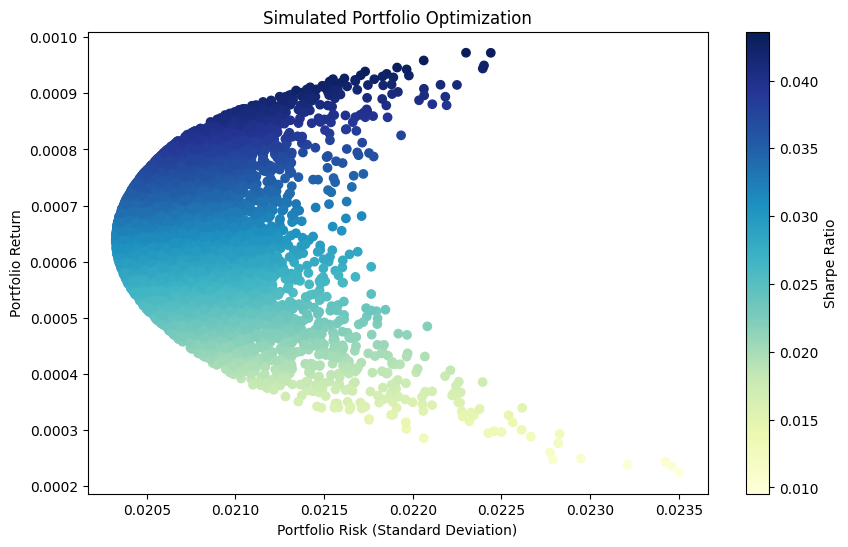

In [86]:
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o')
plt.title('Simulated Portfolio Optimization')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()